# 从零手搓中文大模型｜🚀Day02

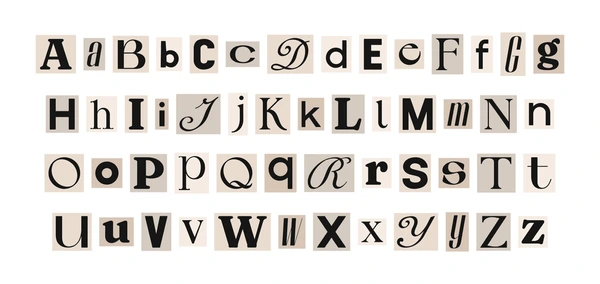

> 原本是计划直接进入「**数据处理**」阶段的，但由于实在精力有限，就拆成两期：这次先说说`Tokenizer`，下一期说**数据处理**。
>
> 由于`Tokenizer`的训练算是一个相对独立的过程，且训练相对来说比较简单，因此我也打算偷懒先用国内大厂开源的，之后有时间再自己训练实现一个。
>
> 其实**分词器**这块的内容经常容易被大家忽略，但实际上是非常重要的，因为它直接决定了模型的输入，进而影响到模型的训练效果。
>
> 这部分内容我自己此前也没怎么深入研究过，所以这次也是一边学习一边写，权当补课了，如果有错误的地方，欢迎指正。

## Tokenizer选择

**tokenization**是大模型训练的第一步，是将文本转换为模型可以理解的数字表示（后面也能反向decode回来）。

其中目前比较主流的是[BPE(Byte Pair Encoding)](https://zhuanlan.zhihu.com/p/424631681)（详细的介绍可以参考链接文章，下面通过例子简单介绍一下原理）。

**BPE**是一种简单的数据压缩形式，这种方法用数据中不存在的一个字节表示最常出现的连续字节数据。这样的替换需要重建全部原始数据。

### BPE简介

假设我们要编码如下数据

> aaabdaaabac

字节对“aa”出现次数最多，所以我们用数据中没有出现的字节“Z”替换“aa”得到替换表

> Z <- aa

数据转变为

> ZabdZabac

在这个数据中，字节对“Za”出现的次数最多，我们用另外一个字节“Y”来替换它（这种情况下由于所有的“Z”都将被替换，所以也可以用“Z”来替换“Za”），得到替换表以及数据

> Z <- aa
> Y <- Za

> YbdYbac

我们再次替换最常出现的字节对得到：

> Z <- aa
> Y <- Za
> X <- Yb

> XdXac

由于不再有重复出现的字节对，所以这个数据不能再被进一步压缩。

解压的时候，就是按照相反的顺序执行替换过程。




![](https://erxuanyi-1257355350.cos.ap-beijing.myqcloud.com/202408201349411.jpeg)

### 测试Tokenizer(以ChatGLM3-6B的tokenizer为例)

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("THUDM/chatglm3-6b", trust_remote_code=True)

Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


编码

In [2]:
print(tokenizer("这是一个测试"))

{'input_ids': [64790, 64792, 30910, 36037, 32882], 'attention_mask': [1, 1, 1, 1, 1], 'position_ids': [0, 1, 2, 3, 4]}


反编码

In [3]:
print(tokenizer.decode(tokenizer("这是一个测试")["input_ids"]))

[gMASK] sop 这是一个测试


⚠️这里可以发现反向解码的时候，多出来了`[gMASK]`和`sop`这两个「奇怪」的token，原因下面会讲到。

我们看看词表的大小：

In [4]:
print(tokenizer.vocab_size)

64798


这里我们写一个函数，针对数据集里的一行`json`文本做处理，得到整行中文文本的编码数组。

In [5]:
import numpy as np


def process_line(line, tokenizer, add_eos=True, dtype=np.uint16):
    js = json.loads(line)
    story = js["story_zh"]
    story = tokenizer.encode(story, add_special_tokens=False)
    if add_eos:
        story.append(tokenizer.eos_token_id)
    # 这里可以用np.unint16，因为我们的vocab_size是小于65536的
    arr = np.array(story, dtype=dtype)
    return arr

❗️这里有几个需要注意的点：
- `add_special_tokens`参数的作用是添加特殊token。
  是chatglm自定义的例如[gMASK]/sop，属于glm架构里特有的（可以参考[这里](https://github.com/THUDM/ChatGLM3/issues/183)）。
  
  由于我们后续并不使用glm的架构，因此这里不需要添加，**直接设置为False**。
- 需要在末尾加上`eos`标记对应的token_id。
- chatglm3-6b使用的词表大小为`64798`，刚好在uint16的表示范围内，所以上面我们给numpy.array设置了`dtype=np.uint16`。

拿一行测试一下：

In [7]:
import json

with open("../../Data/TinyStoriesChinese/raw_data/train/data00_zh.jsonl", "r") as f:
    for line in f.readlines():
        data = process_line(line, tokenizer)
        print(data)
        print(tokenizer.decode(data))
        break

[30910 56623 56623 54542 50154 31761 31155 31633 31815 54534 32693 54662
 55409 31155 35632 31123 31633 34383 57427 47658 54578 34518 31623 55567
 55226 31155 56623 56623 54695 39887 32437 55567 55226 31155 54790 41309
 52624 31123 56856 32660 55567 55226 31155    13 30955 54834 54546 31123
 54613 31404 30955 36213 31155 54613 36660 54563 54834 43881 32024 31155
 56623 56623 32707 54657 33436 31155 54790 54937 56567 40714 31123 38502
 56653 55483 31155    13 54613 32984 56623 56623 31155 54572 31897 54790
 54657 35245 31155 36551 54695 56567 55567 55226 31155 33152 56623 56623
 51556 31797 39055 31155 31694 56623 56623 31631 51556 31155 54790 54937
 56567 54937 54929 31155 54790 55409 40915 34492 54537 31155    13 30955
 54546 32591 56567 55567 55226 55398 31123 56623 56623 31514 30955 54613
 54761 31155 56623 56623 54721 33906 31804 54887 31155 54790 46977 56567
 55567 55226 31155 54613 31897 32960 54597 31155 54572 54942 34675 31155
    13 56623 56623 56567 40915 54589 31123 36467 33

### 选择ChatGLM3-6B的tokenizer的原因

该词表大小为`64798`，值得注意的是：这是一个很**妙**的数字，因为它<u>**刚好在uint16的表示范围（0～65535的无符号整数）**</u>，每一个token只需要两个字节即可表示。

当我们的语料较大时候，相比常用的`int32`可以**节省一半的存储空间**。

另外这里选择一个小尺寸的词表还有一个更重要的原因：我们后面的模型会选择一个小参数量的，如果词表过大，会导致**大部分参数被embedding层占用**，而无法训练出更好的模型。

## 小结
1. 首先熟悉了一下`BPE`的原理
2. 测试了一下`ChatGLM3-6B`的tokenizer
3. 编写了一个函数，用于将一行json文本转换为token_id数组
4. 解释了为什么选择`ChatGLM3-6B`的tokenizer